# Import

In [1]:
from pandas_data_reader_service_core.modules.finam.search_service import Search, Market
from pandas_data_reader_service_core.modules.finam.stock_info import FinamStockInfo
from pandas_data_reader_service_core.service import PandasDataReaderService as pdrs, StockInfo, TimeFrame
from datetime import date
import seaborn as sns
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np

In [2]:
stock = "EURUSD"
market = Market.CURRENCIES_WORLD
vol = "V"
middle_price = "MidPrice"
price_type = "PriceType"
price_value = "Price"
interval_value = "PriceInterval"
price_from = "PriceFrom"
price_till = "PriceTill"
price_value_group = "PriceGroup"
volume_price_col_name = "VolumePrice"
log_volume_price_col_name = "LogVolumePrice"
nlog_volume_price_col_name = "NLogVolumePrice"

# Build data

## Load data

In [3]:
stock_list = Search.by_code(stock, market)
stock_list

,name,code,market
id,,,
83,Eur/Usd,EURUSD,5


In [4]:
stock_info = StockInfo.init_for_Finam(FinamStockInfo(stock_list.index[0]))
print(stock_info)

Source StockSource.Finam source StockInfo Market 5 code EURUSD index 83


In [5]:
date_from = date(2015,1,1)
date_till = date(2020,2,1)
tf = TimeFrame.HOURLY

In [6]:
data_df = pdrs().get(stock=stock_info,  date_from=date_from,date_to=date_till,time_frame=tf,short_col_name=True)
data_df

,O,H,L,C,V
DT,,,,,
2015-01-01 00:00:00,1.20986,1.21079,1.20970,1.21006,26264
2015-01-01 01:00:00,1.21005,1.21037,1.20960,1.21009,15605
2015-01-01 02:00:00,1.21016,1.21024,1.20950,1.21005,14092
2015-01-01 03:00:00,1.21003,1.21008,1.20948,1.20970,10195
2015-01-01 04:00:00,1.20971,1.21000,1.20948,1.20959,136
...,...,...,...,...,...
2020-01-31 21:00:00,1.10828,1.10836,1.10760,1.10799,69886
2020-01-31 22:00:00,1.10800,1.10902,1.10780,1.10894,78526
2020-01-31 23:00:00,1.10891,1.10919,1.10830,1.10904,56848


## Prepare data

### Middle price

In [7]:
data_df[middle_price] = (data_df["C"] + data_df["O"])/2
data_df

,O,H,L,C,V,MidPrice
DT,,,,,,
2015-01-01 00:00:00,1.20986,1.21079,1.20970,1.21006,26264,1.209960
2015-01-01 01:00:00,1.21005,1.21037,1.20960,1.21009,15605,1.210070
2015-01-01 02:00:00,1.21016,1.21024,1.20950,1.21005,14092,1.210105
2015-01-01 03:00:00,1.21003,1.21008,1.20948,1.20970,10195,1.209865
2015-01-01 04:00:00,1.20971,1.21000,1.20948,1.20959,136,1.209650
...,...,...,...,...,...,...
2020-01-31 21:00:00,1.10828,1.10836,1.10760,1.10799,69886,1.108135
2020-01-31 22:00:00,1.10800,1.10902,1.10780,1.10894,78526,1.108470
2020-01-31 23:00:00,1.10891,1.10919,1.10830,1.10904,56848,1.108975


### Column into rows

In [8]:
prepared_df = data_df.melt(id_vars=[vol], 
                            var_name=price_type, 
                            value_name=price_value)
len(prepared_df)

163430

In [9]:
prepared_df = prepared_df.groupby([price_type, price_value]).sum().reset_index()
print(len(prepared_df))
prepared_df.head()

66650


,PriceType,Price,V
0,C,1.03558,108744
1,C,1.03696,101939
2,C,1.03713,102614
3,C,1.03739,142222
4,C,1.03766,107396


### Разделяем на фичи

In [10]:
prepared_df = prepared_df[prepared_df[price_type]==middle_price][[price_value, vol]]
prepared_df.head()

,Price,V
32390,1.036265,101939
32391,1.036705,108744
32392,1.037040,102614
32393,1.037400,107396
32394,1.038325,99383


### Create VolumePriceMult

In [11]:
prepared_df[volume_price_col_name] = prepared_df[price_value] * prepared_df[vol]
prepared_df.head()

,Price,V,VolumePrice
32390,1.036265,101939,105635.817835
32391,1.036705,108744,112735.448520
32392,1.037040,102614,106414.822560
32393,1.037400,107396,111412.610400
32394,1.038325,99383,103191.853475


### Grouping

In [12]:
from src.SupportLines.GroupFactory import split_by_count,classify_price_sr_by_group,group_col_name

In [13]:
group_count = 200

In [14]:
min_pv = prepared_df[price_value].min()
max_pv = prepared_df[price_value].max()
interval, groups = split_by_count(min_pv, max_pv, group_count)
print(f'min = {min_pv}, max = {max_pv}, interval = {interval}')
groups

min = 1.0362650000000002, max = 1.25487, interval = 0.0010930249999999986


,From,Till,GR
0,1.036265,1.037358,"(1.0362650000000002, 1.0373580250000003)"
1,1.037358,1.038451,"(1.0373580250000003, 1.0384510500000004)"
2,1.038451,1.039544,"(1.0384510500000004, 1.0395440750000005)"
3,1.039544,1.040637,"(1.0395440750000005, 1.0406371000000005)"
4,1.040637,1.041730,"(1.0406371000000005, 1.0417301250000006)"
...,...,...,...
195,1.249405,1.250498,"(1.249404875000016, 1.250497900000016)"
196,1.250498,1.251591,"(1.250497900000016, 1.2515909250000161)"
197,1.251591,1.252684,"(1.2515909250000161, 1.2526839500000162)"
198,1.252684,1.253777,"(1.2526839500000162, 1.2537769750000163)"


In [15]:
prepared_df[price_value_group] = classify_price_sr_by_group(prepared_df[price_value],groups_sr=groups[group_col_name])
prepared_df

,Price,V,VolumePrice,PriceGroup
32390,1.036265,101939,105635.817835,1
32391,1.036705,108744,112735.448520,1
32392,1.037040,102614,106414.822560,1
32393,1.037400,107396,111412.610400,2
32394,1.038325,99383,103191.853475,2
...,...,...,...,...
53247,1.253310,97892,122689.022520,199
53248,1.253860,49017,61460.455620,200
53249,1.254340,54616,68507.033440,200
53250,1.254370,94039,117959.700430,200


### Define group volumes

In [16]:
grouped_df = prepared_df[[price_value_group,vol,volume_price_col_name]].groupby([price_value_group]).sum().reset_index()
grouped_df

,PriceGroup,V,VolumePrice
0,1,313297,3.247861e+05
1,2,356459,3.700335e+05
2,3,1964683,2.041445e+06
3,4,1451179,1.509525e+06
4,5,1593655,1.659174e+06
...,...,...,...
195,196,1155955,1.444776e+06
196,197,492173,6.155915e+05
197,198,85839,1.075146e+05
198,199,309690,3.880969e+05


### Логарифмическая трансформация

In [29]:
from src.Tool.DataPreparation import normilize, log_tr

In [30]:
grouped_df[log_volume_price_col_name] = log_tr(grouped_df[volume_price_col_name])
grouped_df[nlog_volume_price_col_name] = normilize(grouped_df[log_volume_price_col_name])
grouped_df

,PriceGroup,V,VolumePrice,LogVolumePrice,NLogVolumePrice
0,1,313297,3.247861e+05,12.326806,0.705293
1,2,356459,3.700335e+05,12.509550,0.715748
2,3,1964683,2.041445e+06,14.479396,0.828455
3,4,1451179,1.509525e+06,14.159387,0.810146
4,5,1593655,1.659174e+06,14.260230,0.815916
...,...,...,...,...,...
195,196,1155955,1.444776e+06,14.112391,0.807457
196,197,492173,6.155915e+05,13.154773,0.752666
197,198,85839,1.075146e+05,9.035203,0.516960
198,199,309690,3.880969e+05,12.574098,0.719442


In [31]:
grouped_df.describe()

,PriceGroup,V,VolumePrice,LogVolumePrice,NLogVolumePrice
count,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000
mean,100.500000,1.051967e+07,1.187460e+07,15.693088,0.897898
std,57.879185,8.941959e+06,9.974766e+06,1.733186,0.099166
min,1.000000,8.148700e+04,9.912222e+04,0.000000,0.000000
25%,50.750000,4.026287e+06,4.693205e+06,15.340241,0.877710
50%,100.500000,7.722572e+06,8.972333e+06,15.998542,0.915375
75%,150.250000,1.406667e+07,1.621632e+07,16.595370,0.949523
max,200.000000,3.486134e+07,3.904092e+07,17.477579,1.000000


### Исключение выбросов

In [32]:
from src.Tool.DataPreparation import handle_outlier

In [36]:
handler = handle_outlier(3)
handler.replace(grouped_df[log_volume_price_col_name])
grouped_df[log_volume_price_col_name] = grouped_df[log_volume_price_col_name] - grouped_df[log_volume_price_col_name].min()
grouped_df

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,PriceGroup,V,VolumePrice,LogVolumePrice,NLogVolumePrice
0,1,313297,3.247861e+05,0.402282,0.705293
1,2,356459,3.700335e+05,0.585026,0.715748
2,3,1964683,2.041445e+06,2.554871,0.828455
3,4,1451179,1.509525e+06,2.234862,0.810146
4,5,1593655,1.659174e+06,2.335705,0.815916
...,...,...,...,...,...
195,196,1155955,1.444776e+06,2.187866,0.807457
196,197,492173,6.155915e+05,1.230248,0.752666
197,198,85839,1.075146e+05,0.000000,0.516960
198,199,309690,3.880969e+05,0.649573,0.719442


In [34]:
grouped_df.describe()

,PriceGroup,V,VolumePrice,LogVolumePrice,NLogVolumePrice
count,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000
mean,100.500000,1.051967e+07,1.187460e+07,15.765887,0.897898
std,57.879185,8.941959e+06,9.974766e+06,1.280454,0.099166
min,1.000000,8.148700e+04,9.912222e+04,10.493529,0.000000
25%,50.750000,4.026287e+06,4.693205e+06,15.340241,0.877710
50%,100.500000,7.722572e+06,8.972333e+06,15.998542,0.915375
75%,150.250000,1.406667e+07,1.621632e+07,16.595370,0.949523
max,200.000000,3.486134e+07,3.904092e+07,17.477579,1.000000


# Analitic

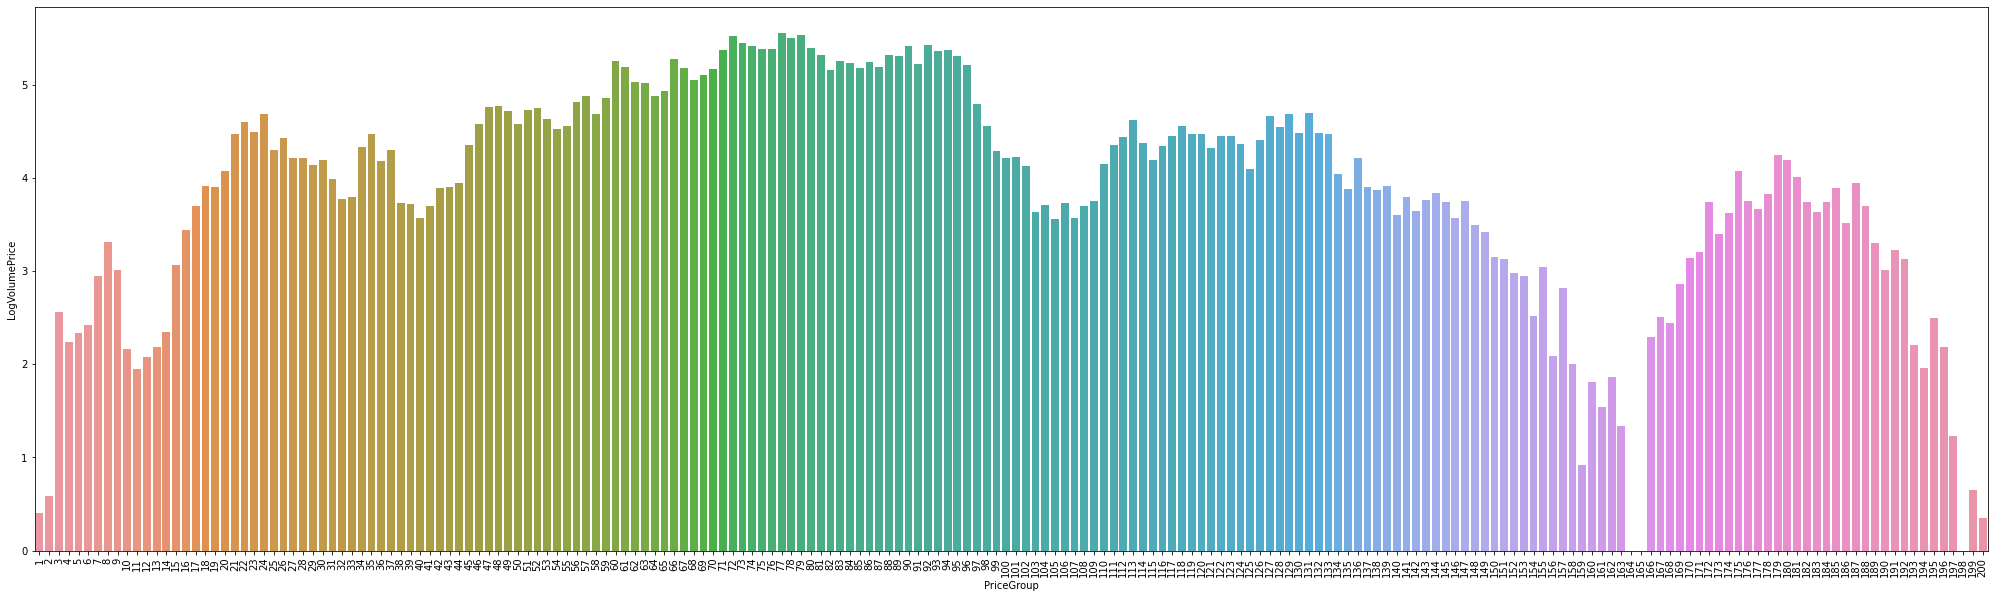

In [37]:
plt.figure(figsize=(35,10))
plt.xticks(rotation=90)
# Draw a nested barplot by species and sex
g = sns.barplot(
    data=grouped_df, 
    x=price_value_group, y=log_volume_price_col_name
)